In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorWithPadding, set_seed, get_scheduler
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm.auto import tqdm


set_seed(
    42, 
    # deterministic=True # this refuses to work:
    )

### Model, Tokenizer, hyperparams prep
# model_id = "HuggingFaceTB/SmolLM2-135M-Instruct"
model_id = "allenai/OLMo-2-0425-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(
    model_id, 
    dtype="bfloat16",
    device_map="cuda:0",
    )
max_length = 2048
batch_size = 1
num_epochs = 1

OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 47.38 GiB of which 22.38 MiB is free. Process 944112 has 44.94 GiB memory in use. Process 3473583 has 2.41 GiB memory in use. Of the allocated memory 1.92 GiB is allocated by PyTorch, and 73.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [2]:
### Dataset prep
# dataset_id = "Neelectric/OpenR1-Math-220k_extended_Llama3_4096toks"
dataset_id = "Neelectric/OpenR1-Math-220k_CN-K12_OLMo-2_4096toks"

dataset_raw = load_dataset(dataset_id)["train"]
dataset_subset = dataset_raw.select(range(0,100))

In [3]:
### Dataset tokenization
system_prompt_content = "You are a helpful AI Assistant that provides well-reasoned and detailed responses. You first think about the reasoning process as an internal monologue and then provide the user with the answer. Respond in the following format: <think>\n...\n</think>\n<answer>\n...\n</answer>"
system_prompt = [{
    "content": system_prompt_content,
    "role": "system"
    }]

def tokenize_function(example):
    messages =  system_prompt + example["messages"]
    templated = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
    tokenized = tokenizer(
        templated, 
        # return_tensors="pt", #it appears this causes addition of redundant batch dimension, e.g.
        # {'input_ids': torch.Size([8, 1, 2048]), 'attention_mask': torch.Size([8, 1, 2048])} instead of {'input_ids': torch.Size([8, 2048]), 'attention_mask': torch.Size([8, 2048])}
        
        # #old vals
        # truncation=True, 
        # padding='max_length',
        # max_length=max_length
        
        # new vals
        truncation=False, 
        padding=False,
        )
    labels = tokenized["input_ids"].copy()
    # we need to be careful to mask padding tokens!!!
    labels = [-100 if token_id == tokenizer.pad_token_id else token_id for token_id in labels]
    tokenized["labels"] = labels
    return tokenized


first_sample = dataset_subset[0]
tokenized = tokenize_function(first_sample)
tokenized_dataset = dataset_subset.map(tokenize_function, num_proc=16)
tokenized_dataset = tokenized_dataset.remove_columns(['problem', 'solution', 'answer', 'problem_type', 'question_type', 'source', 'uuid', 'is_reasoning_complete', 'generations', 'correctness_math_verify', 'correctness_llama', 'finish_reasons', 'correctness_count', 'messages'])
print(tokenized_dataset)

Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

Dataset({
    features: ['tokenized', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 100
})


In [4]:
### Data Collator and Data Loader prep
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(
    tokenized_dataset, shuffle=True, batch_size=batch_size, collate_fn=data_collator
)
for batch in train_dataloader:
    break
# batched = {k: v.shape for k, v in batch.items()}
# print(batched)
# outputs = model(**batch.to(model.device))
# print(outputs)
batch["input_ids"]

tensor([[100257,     27,     91,  ...,  11281,    570, 100257]])

In [5]:
tokenizer.decode(batch["input_ids"][0])

'<|endoftext|><|system|>\nYou are a helpful AI Assistant that provides well-reasoned and detailed responses. You first think about the reasoning process as an internal monologue and then provide the user with the answer. Respond in the following format: <think>\n...\n</think>\n<answer>\n...\n</answer>\n<|user|>\nFor a point P on the hyperbola $4x^2 - y^2 + 64 = 0$, the distance from P to one of its foci is equal to 1. Determine the distance from point P to the other focus.\n<|assistant|>\n<think>\nOkay, so I have this hyperbola equation: 4x² - y² + 64 = 0. Hmm, first I need to write it in the standard form. Let me recall that the standard form of a hyperbola is either (x²/a²) - (y²/b²) = 1 or (y²/a²) - (x²/b²) = 1. \n\nLet me rearrange the given equation to see which one it is. Starting with 4x² - y² = -64. If I divide both sides by -64 to get 1 on the right, it becomes (y²/64) - (x²/16) = 1. Oh, right, so this is a hyperbola that opens upwards and downwards. The center is at (0,0) sin

# Let's compute the Fisher Diagonal

In [6]:
batch["input_ids"].shape

torch.Size([1, 3063])

In [7]:
print(len(train_dataloader))

100


In [8]:
num_training_steps = num_epochs * len(train_dataloader)
print(f"Training for {num_training_steps} steps")
device = model.device
progress_bar = tqdm(range(num_training_steps))

from copy import deepcopy
import torch


fisher = {}
params = {name: param for name, param in model.named_parameters() if param.requires_grad}
for name, param in deepcopy(params).items():
    param.data.zero_()
    fisher[name] = param.data

### fisher estimation loop
model.eval()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        # print(outputs)
        progress_bar.update(1)
        tqdm.write(f"loss is {loss}")
        for name, param in model.named_parameters():
            fisher[name].data += param.grad.data ** 2 / len(train_dataloader)
    break

Training for 100 steps


  0%|          | 0/100 [00:00<?, ?it/s]

loss is 1.5662636756896973
loss is 1.200555682182312
loss is 1.4436537027359009
loss is 0.8905612826347351
loss is 1.1050221920013428
loss is 1.8255066871643066
loss is 1.2515181303024292
loss is 0.969562828540802
loss is 1.5710978507995605
loss is 1.1416254043579102
loss is 1.3075523376464844
loss is 1.2862629890441895
loss is 1.1426550149917603
loss is 1.4506818056106567
loss is 1.2653794288635254
loss is 1.4711757898330688
loss is 1.0571396350860596
loss is 1.2706325054168701
loss is 1.5068830251693726
loss is 1.4079186916351318
loss is 1.3075482845306396
loss is 1.0531083345413208
loss is 1.1749954223632812
loss is 0.9875829815864563
loss is 1.6013790369033813
loss is 1.2741174697875977
loss is 0.9043805003166199
loss is 1.084376335144043
loss is 1.296737790107727
loss is 1.6500473022460938
loss is 1.222772479057312
loss is 1.0816028118133545
loss is 1.3912864923477173
loss is 1.2406800985336304
loss is 1.408964991569519
loss is 1.1427175998687744
loss is 1.4605685472488403
loss is

In [9]:
params['model.embed_tokens.weight'][0]

tensor([-0.0374, -0.0176,  0.0303,  ...,  0.0898,  0.0154, -0.0012],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<SelectBackward0>)

In [10]:
fisher['model.embed_tokens.weight'][0]

tensor([1.4082e-06, 4.2841e-07, 1.8030e-06,  ..., 7.1898e-07, 6.6310e-07,
        1.7285e-06], device='cuda:0', dtype=torch.bfloat16)

# let's try and plot this?

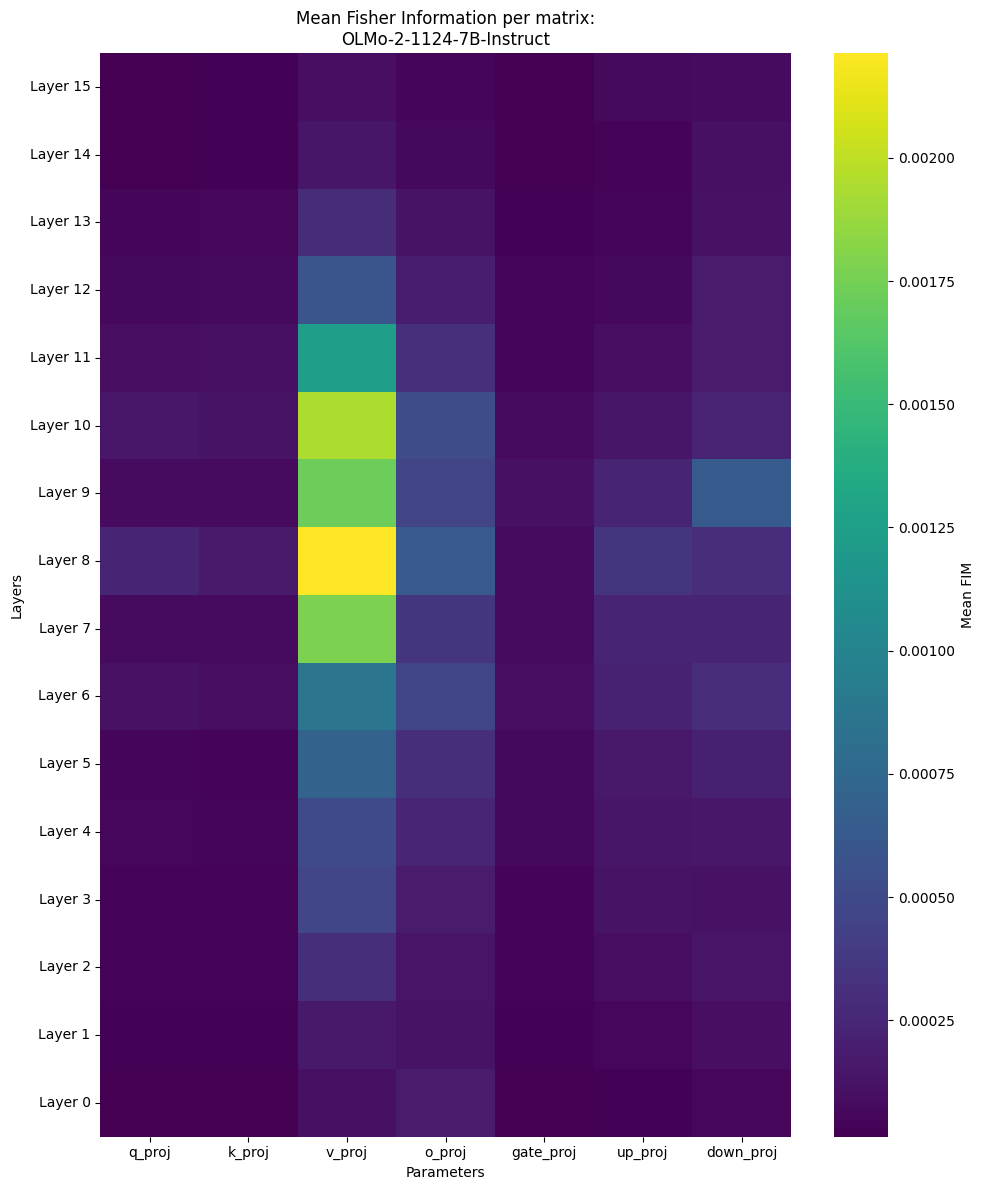

In [11]:


import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define parameter types in order (matching your plot)
param_types = ['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj']

# Adjust based on your model
num_layers = len(model.model.layers)

# Create matrix to store mean FIM values
fim_matrix = np.zeros((num_layers, len(param_types)))

# Populate the matrix
for name, fim_values in fisher.items():
    for i, ptype in enumerate(param_types):
        if ptype in name:
            # Extract layer number (assumes naming like model.layers.X....)
            parts = name.split('.')
            for j, part in enumerate(parts):
                if part == 'layers' and j + 1 < len(parts):
                    layer_num = int(parts[j + 1])
                    # Option 1: mean FIM (normalized by param count)
                    fim_matrix[layer_num, i] = fim_values.mean().item()
                    break
            break

# Create DataFrame
df = pd.DataFrame(fim_matrix, 
                  index=[f'Layer {i}' for i in range(num_layers)],
                  columns=param_types)

# Reverse so Layer 31 is at top
df = df.iloc[::-1]

# Plot
plt.figure(figsize=(10, 12))
sns.heatmap(df, cmap='viridis', cbar_kws={'label': 'Mean FIM'})
plt.xlabel('Parameters')
plt.ylabel('Layers')
plt.title('Mean Fisher Information per matrix:\nOLMo-2-1124-7B-Instruct')
plt.tight_layout()
plt.savefig('fim_heatmap.png', dpi=150)
plt.show()